<a href="https://colab.research.google.com/github/marcinwolter/NORCC-SUMMER_2022/blob/main/GAN_mode_colapse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='green'>**Simple implementation of Generative Adversarial Neural Network**

# <font color='red'>**The gan is failing - mode collapse**

In [1]:
""" Simple implementation of Generative Adversarial Neural Network """

import numpy as np

#from IPython.core.debugger import Tracer

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv2D
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
#plt.switch_backend('agg')   # allows code to run without a system DISPLAY



# Define GAN network

In [2]:

class GAN(object):
    """ Generative Adversarial Network class """
    def __init__(self, width=28, height=28, channels=1):

        self.width = width
        self.height = height
        self.channels = channels

        self.shape = (self.width, self.height, self.channels)

        self.optimizer = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)

        self.G = self.__generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)

        self.D = self.__discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])

        self.stacked_generator_discriminator = self.__stacked_generator_discriminator()

        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)


    def __generator(self):
        """ Declare generator """

        model = Sequential()
        model.add(Dense(256, input_shape=(100,)))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.width  * self.height * self.channels, activation='tanh'))
        model.add(Reshape((self.width, self.height, self.channels)))

        return model

    def __discriminator(self):
        """ Declare discriminator """

        model = Sequential()
        model.add(Conv2D(64,(3,3), input_shape=self.shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.2))
        model.add(Conv2D(128,(3,3), input_shape=self.shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.2))
        model.add(Conv2D(256,(3,3), input_shape=self.shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.2))
        #model.add(Flatten(input_shape=self.shape))
        #model.add(Dense(15*(self.width * self.height * self.channels), input_shape=self.shape))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(Dense(15*np.int64((self.width * self.height * self.channels)/2)))
        #model.add(LeakyReLU(alpha=0.2))    
        model.add(Flatten())           
        model.add(Dense(np.int64((self.width * self.height * self.channels))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.int64((self.width * self.height * self.channels))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))

        return model

    def __stacked_generator_discriminator(self):

        self.D.trainable = False

        model = Sequential()
        model.add(self.G)
        model.add(self.D)

        return model

    def train(self, X_train, epochs=15000, batch = 32, save_interval = 500):

        for cnt in range(epochs):

            ## train discriminator
            random_index = np.random.randint(0, len(X_train) - batch/2)
            legit_images = X_train[random_index : random_index + int(batch/2)].reshape(int(batch/2), self.width, self.height, self.channels)

            gen_noise = np.random.normal(0, 1, (int(batch/2), 100))
            syntetic_images = self.G.predict(gen_noise)

            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((int(batch/2), 1)), np.zeros((int(batch/2), 1))))

            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)


            # train generator

            noise = np.random.normal(0, 1, (batch, 100))
            y_mislabled = np.ones((batch, 1))

            g_loss = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)

            if cnt % save_interval == 0:
                print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))

            if cnt % save_interval == 0:
                self.plot_images(save2file=False, step=cnt)

    # Define plotting function
    def plot_images(self, save2file=False, samples=16, step=0):
        ''' Plot generated images '''
        filename = "./mnist_%d.png" % step
        noise = np.random.normal(0, 1, (samples, 100))

        images = self.G.predict(noise)

        plt.figure(figsize=(7, 7))

        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.height, self.width])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()

        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()



# Actual training

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


epoch: 0, [Discriminator :: d_loss: 0.712982], [ Generator :: loss: 0.360095]


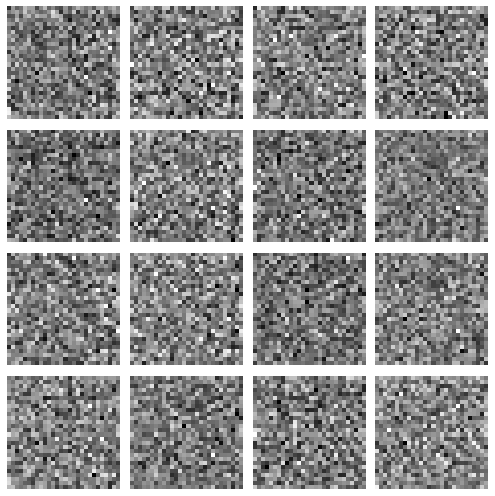

epoch: 500, [Discriminator :: d_loss: 0.015637], [ Generator :: loss: 6.542722]


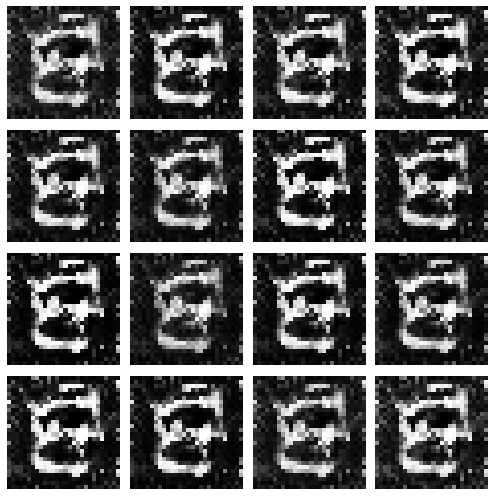

epoch: 1000, [Discriminator :: d_loss: 0.080389], [ Generator :: loss: 7.134472]


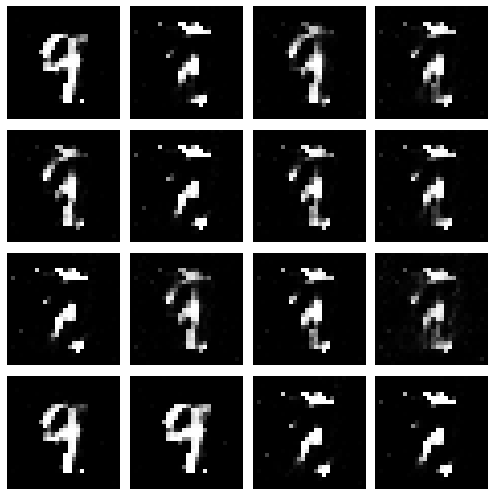

epoch: 1500, [Discriminator :: d_loss: 0.003564], [ Generator :: loss: 5.805273]


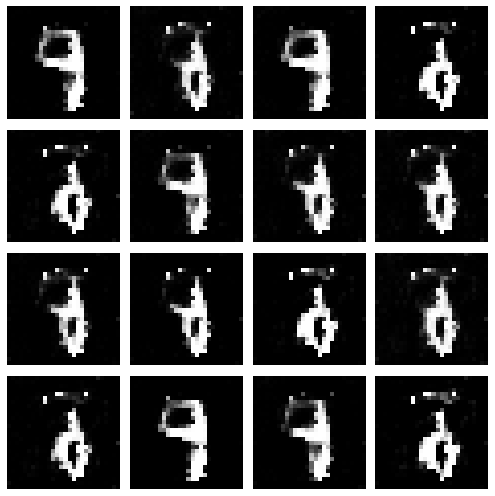

epoch: 2000, [Discriminator :: d_loss: 0.027173], [ Generator :: loss: 7.074005]


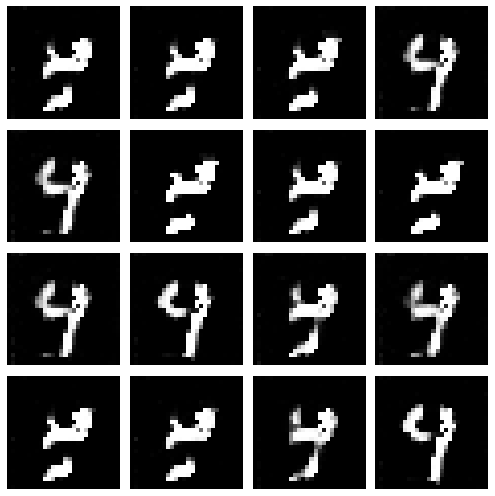

epoch: 2500, [Discriminator :: d_loss: 0.006808], [ Generator :: loss: 6.206203]


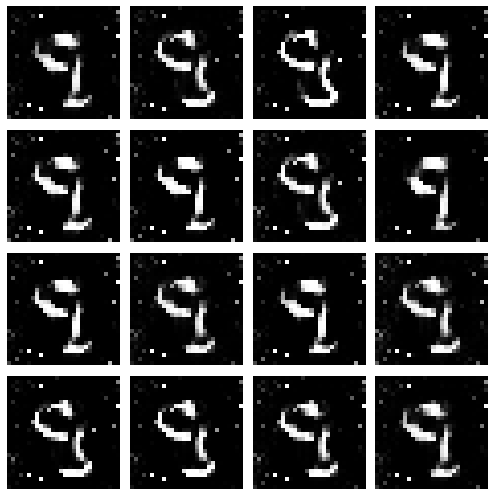

epoch: 3000, [Discriminator :: d_loss: 0.000054], [ Generator :: loss: 30.627815]


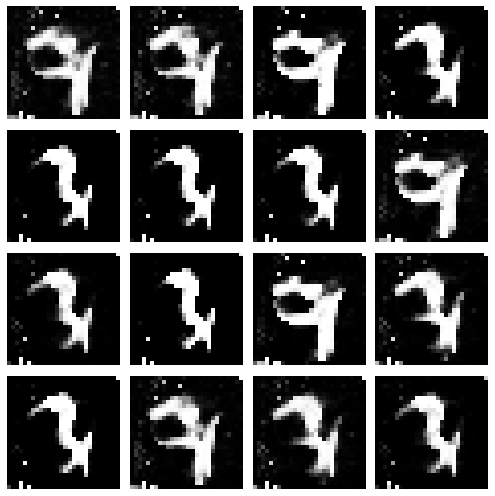

epoch: 3500, [Discriminator :: d_loss: 0.002572], [ Generator :: loss: 5.940235]


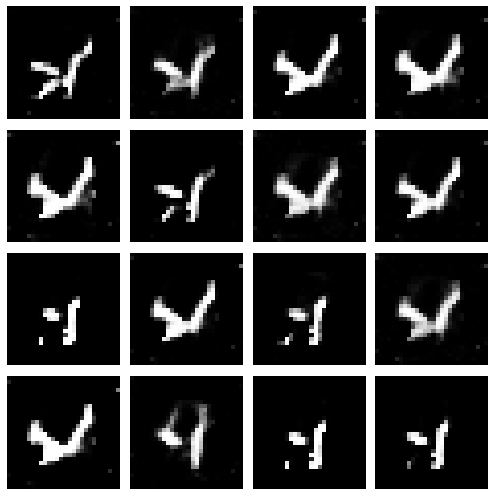

epoch: 4000, [Discriminator :: d_loss: 0.011507], [ Generator :: loss: 7.885495]


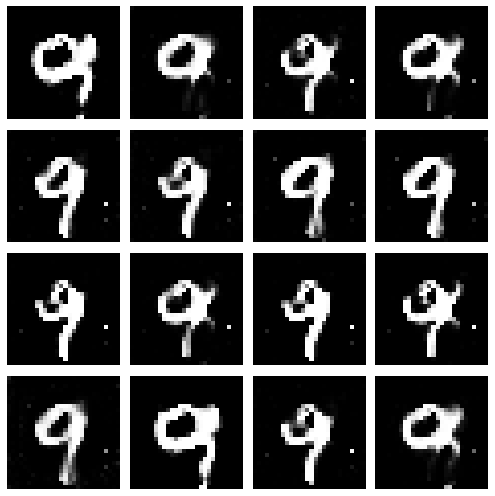

epoch: 4500, [Discriminator :: d_loss: 0.006901], [ Generator :: loss: 5.536664]


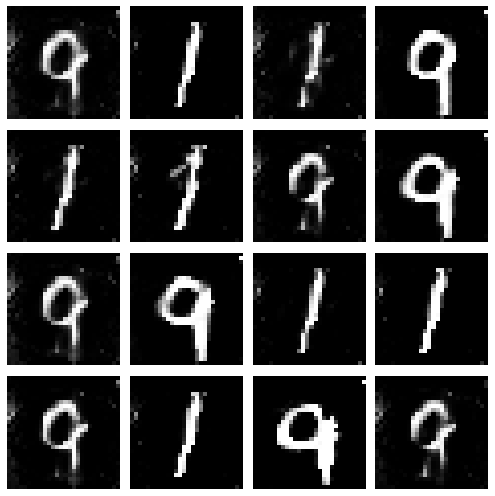

epoch: 5000, [Discriminator :: d_loss: 0.365806], [ Generator :: loss: 6.942540]


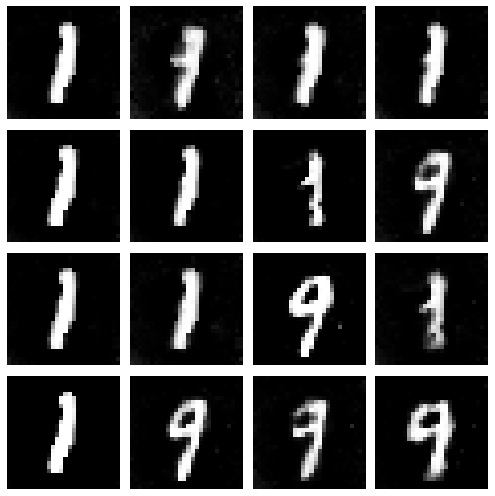

epoch: 5500, [Discriminator :: d_loss: 0.184864], [ Generator :: loss: 2.894716]


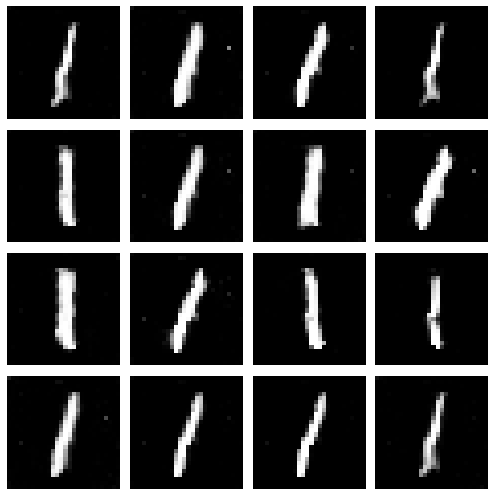

epoch: 6000, [Discriminator :: d_loss: 0.090337], [ Generator :: loss: 3.879566]


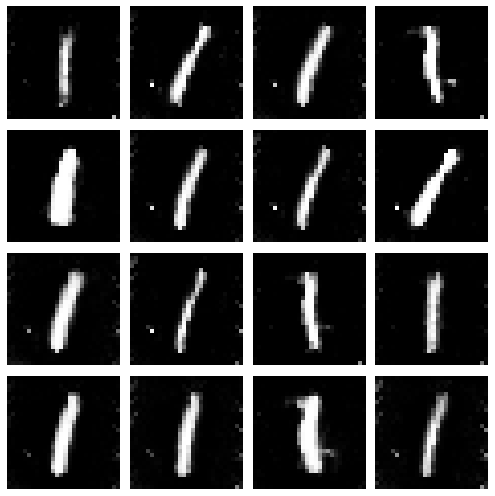

epoch: 6500, [Discriminator :: d_loss: 0.106208], [ Generator :: loss: 3.450972]


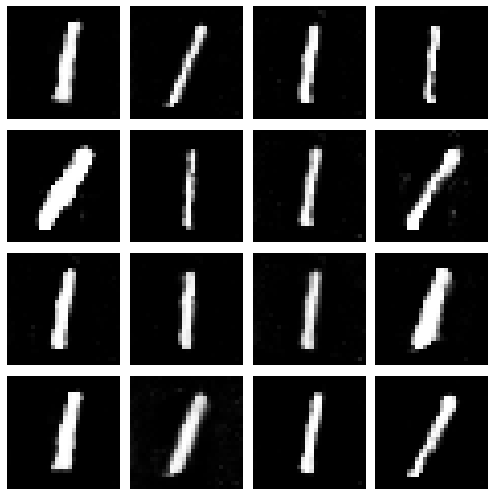

epoch: 7000, [Discriminator :: d_loss: 0.243298], [ Generator :: loss: 2.611437]


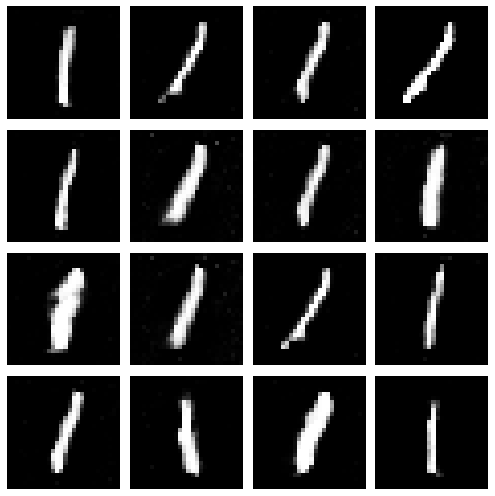

epoch: 7500, [Discriminator :: d_loss: 0.103351], [ Generator :: loss: 3.232232]


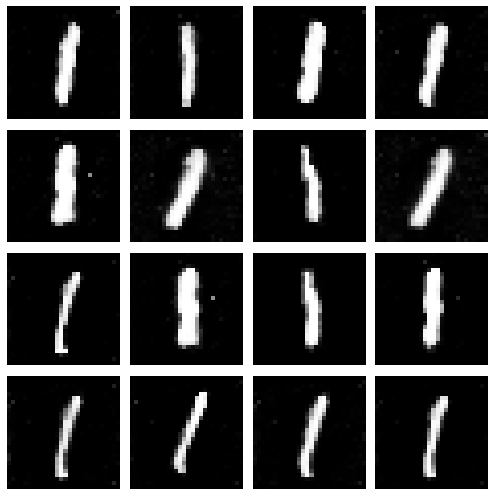

epoch: 8000, [Discriminator :: d_loss: 0.144165], [ Generator :: loss: 2.921362]


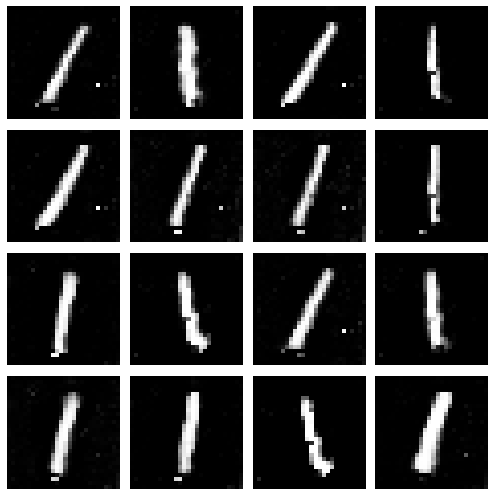

epoch: 8500, [Discriminator :: d_loss: 0.079202], [ Generator :: loss: 2.731885]


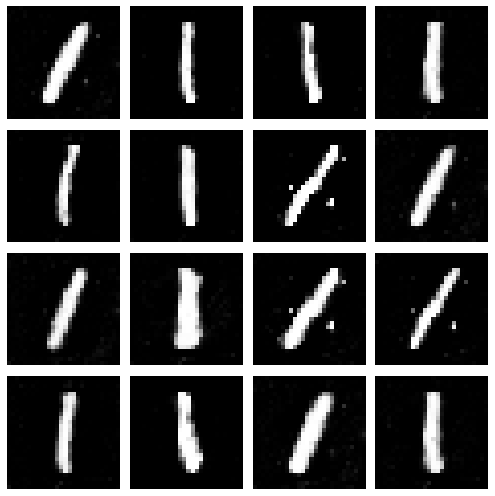

epoch: 9000, [Discriminator :: d_loss: 0.360158], [ Generator :: loss: 1.244458]


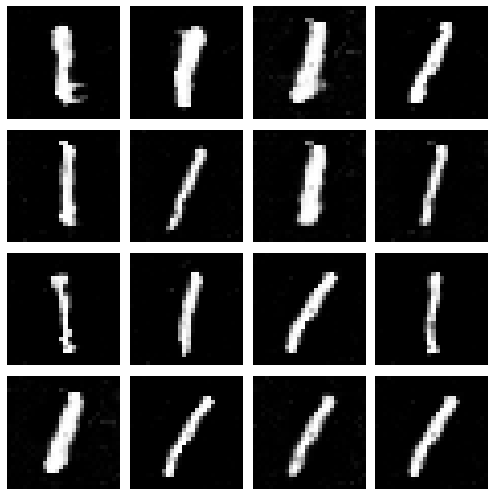

epoch: 9500, [Discriminator :: d_loss: 0.112154], [ Generator :: loss: 3.122381]


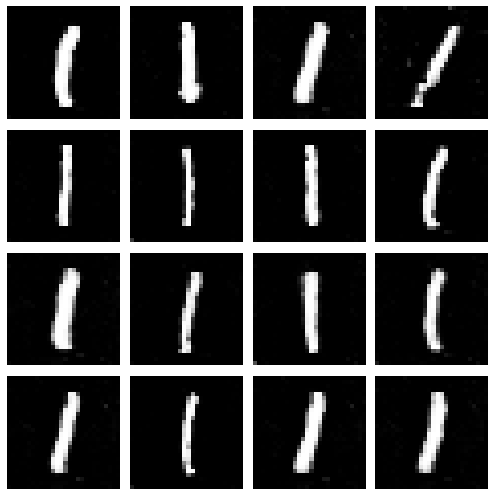

epoch: 10000, [Discriminator :: d_loss: 0.153226], [ Generator :: loss: 2.346510]


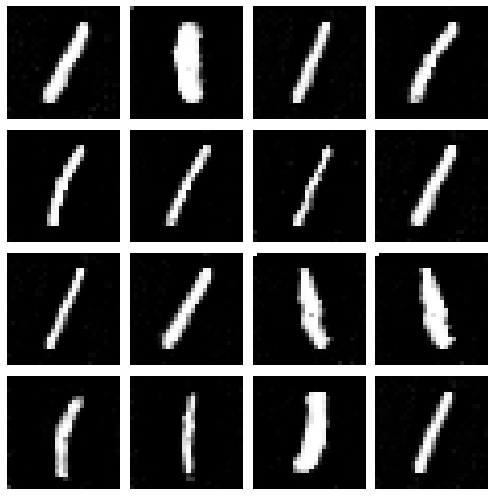

epoch: 10500, [Discriminator :: d_loss: 0.078258], [ Generator :: loss: 2.607669]


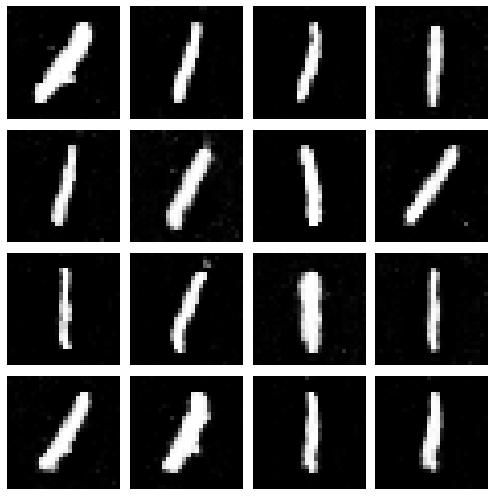

epoch: 11000, [Discriminator :: d_loss: 0.032693], [ Generator :: loss: 3.389273]


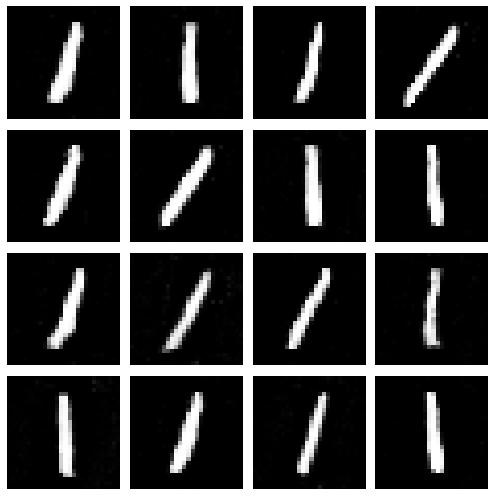

epoch: 11500, [Discriminator :: d_loss: 0.116603], [ Generator :: loss: 2.792480]


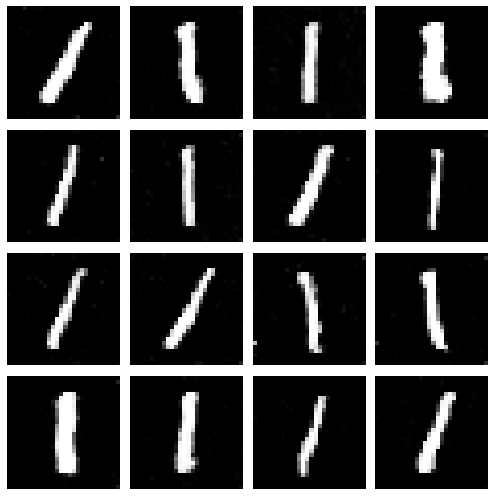

epoch: 12000, [Discriminator :: d_loss: 0.258542], [ Generator :: loss: 2.991046]


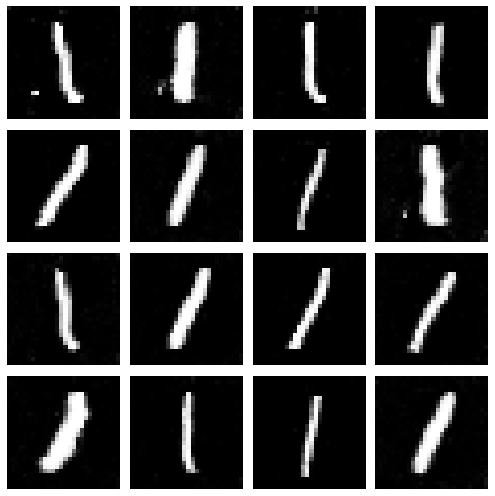

epoch: 12500, [Discriminator :: d_loss: 0.016122], [ Generator :: loss: 4.426102]


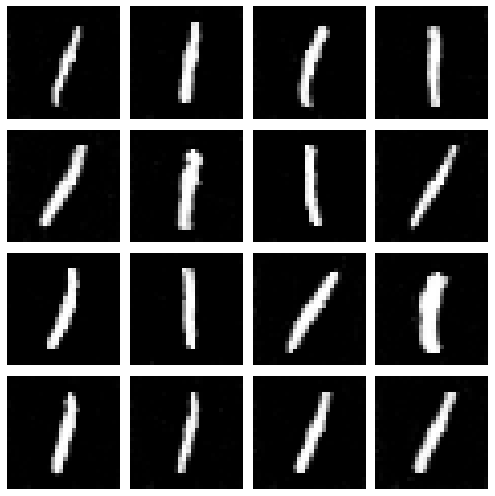

epoch: 13000, [Discriminator :: d_loss: 0.082438], [ Generator :: loss: 2.846040]


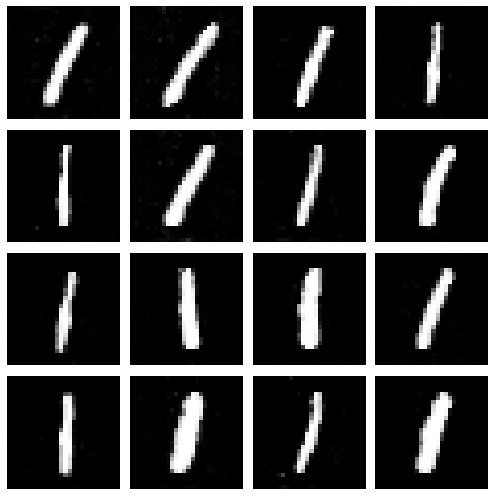

epoch: 13500, [Discriminator :: d_loss: 0.232579], [ Generator :: loss: 2.774521]


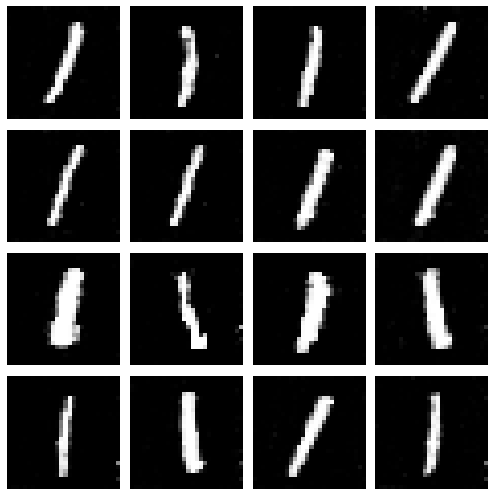

epoch: 14000, [Discriminator :: d_loss: 0.194311], [ Generator :: loss: 3.454234]


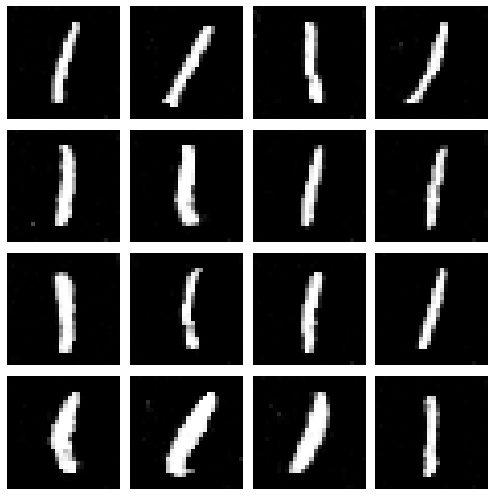

epoch: 14500, [Discriminator :: d_loss: 0.136971], [ Generator :: loss: 3.310114]


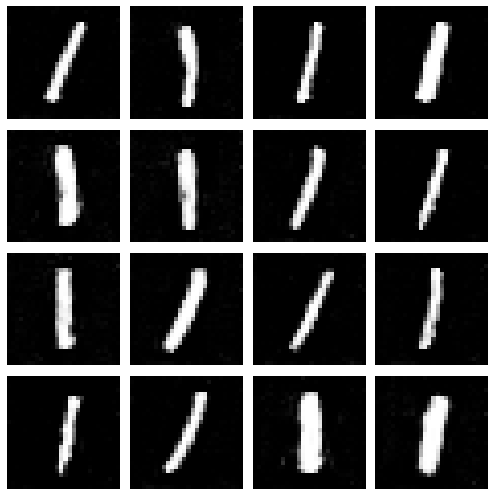

In [3]:

if __name__ == '__main__':
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)


    gan = GAN()

    gan.train(X_train)



---

